In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [5]:
def plot(dataset):
    datasize = pd.read_csv('../training_data/' + dataset + '/target.csv').shape[0]

    # Load the CSV data
    data = pd.read_csv('../acc_rate_csvs/' + dataset + '.csv')

    # Convert the numeric part of the method name to three-digit format
    data['method'] = data['method'].apply(lambda x: x.split('.')[0] + '.' + f"{int(x.split('.')[1]):03d}")

    # Group by method and calculate mean and standard deviation for accuracy
    grouped = data.groupby('method')['acc'].agg(['mean', 'std']).reset_index()

    # Sort by mean accuracy
    grouped_sorted = grouped.sort_values('mean')

    # Drop the 5 methods with the smallest mean accuracy
    grouped_filtered = grouped_sorted.iloc[3:]

    # Restore the original order by sorting based on the index
    grouped_filtered = grouped_filtered.sort_index()

    # Plotting
    plt.figure(figsize=(8, 4))

    # Plot methods
    for _, row in grouped_filtered.iterrows():
        color = 'red' if row['method'].startswith('mlp') else ('blue' if row['method'].startswith('rf') else 'black')
        plt.errorbar(row['mean'], row['method'], xerr=0.2 * row['std'], fmt='o', color=color, capsize=5, capthick=2, elinewidth=2)

    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Add labels and title
    plt.ylabel('Method')
    plt.xlabel('Accuracy')
    plt.title('Mean Accuracy and Standard Deviation of Each Method: ' + dataset + f" (N = {datasize})")

    # Show plot
    plt.tight_layout()
    plt.show()

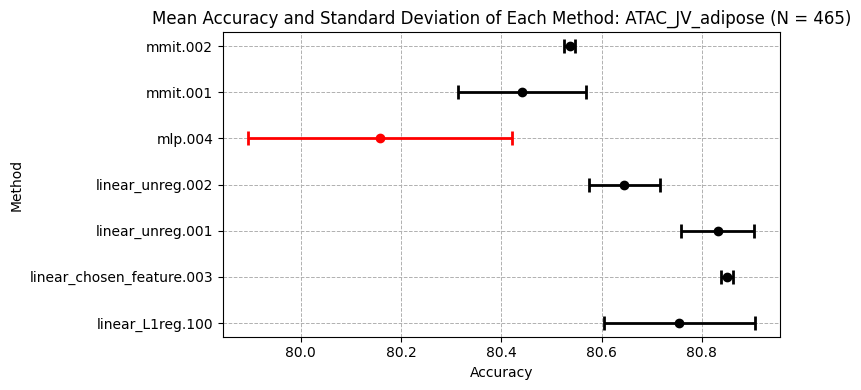

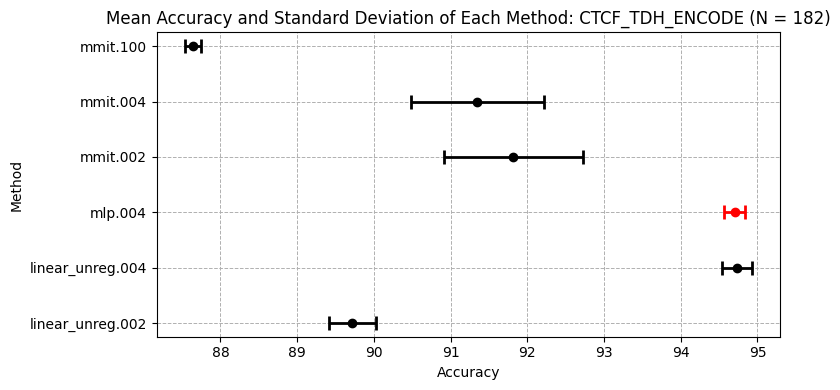

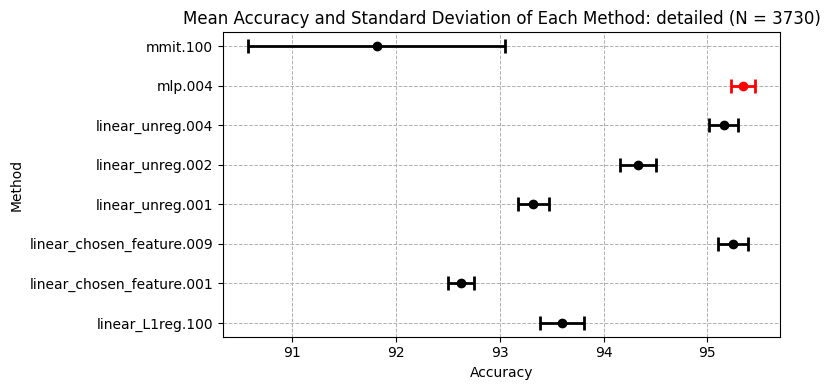

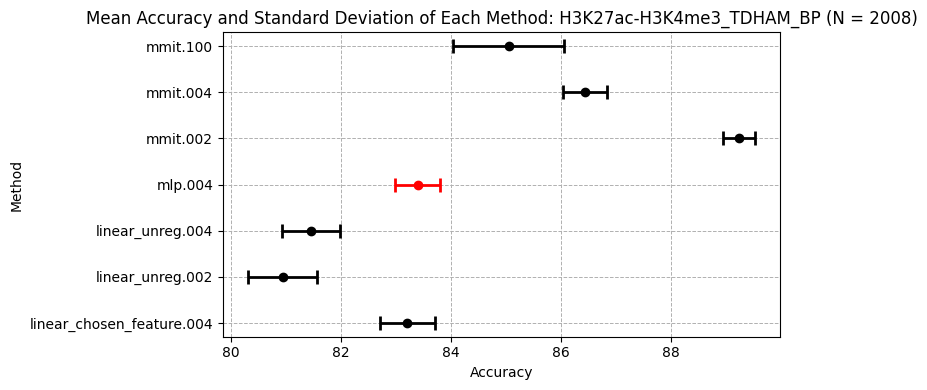

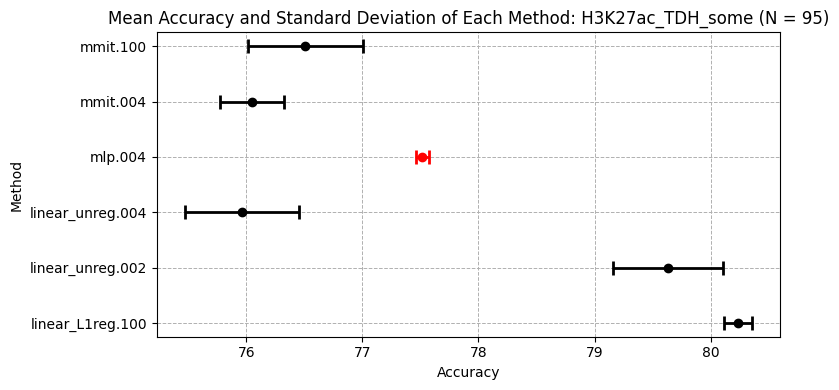

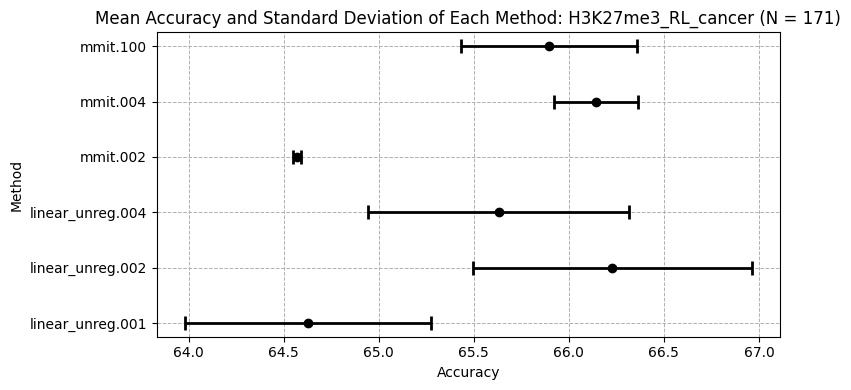

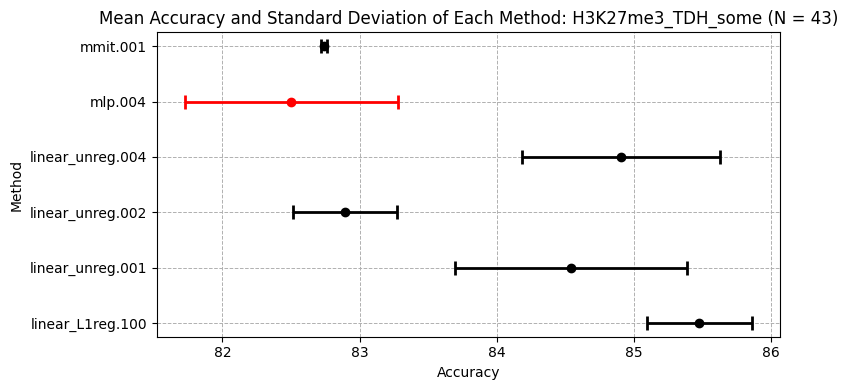

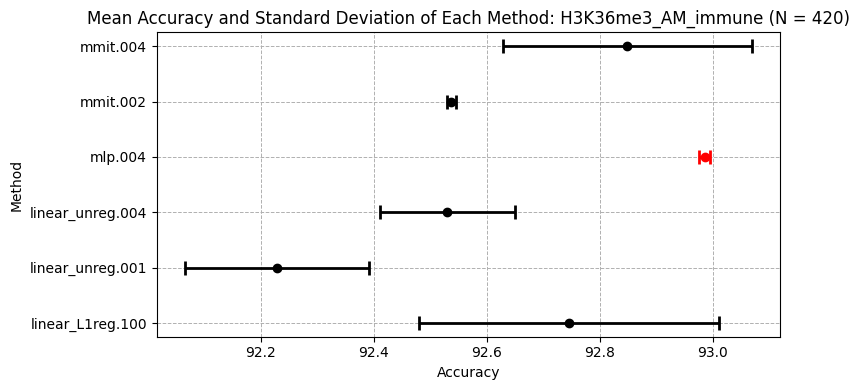

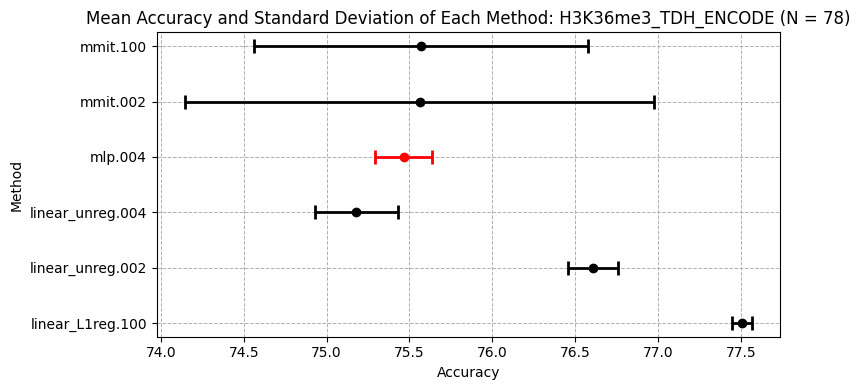

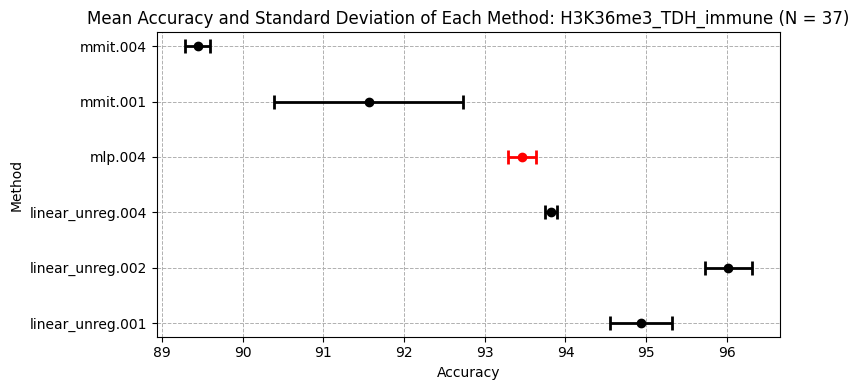

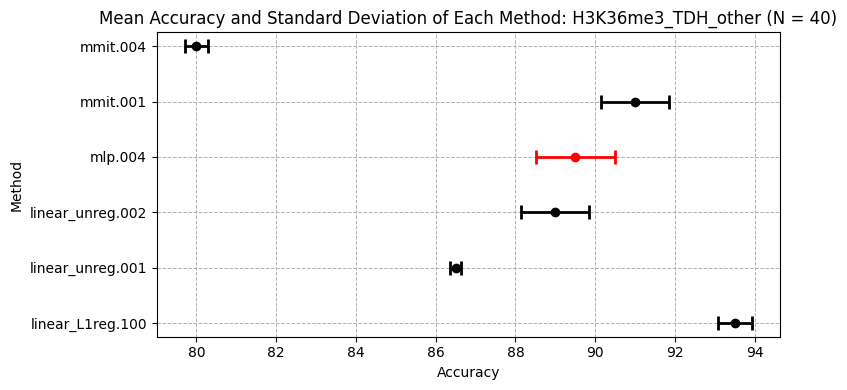

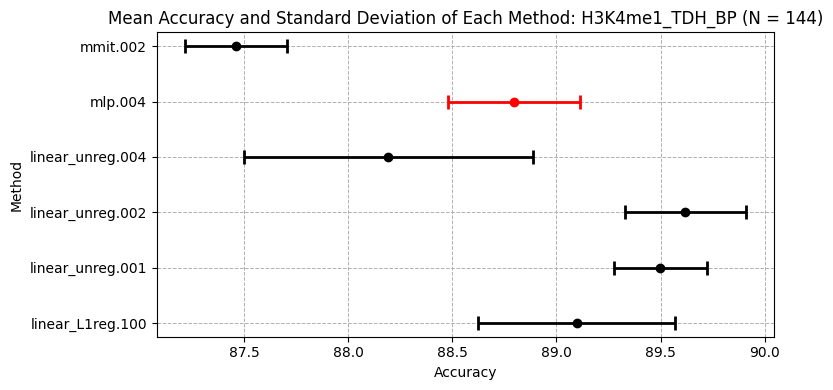

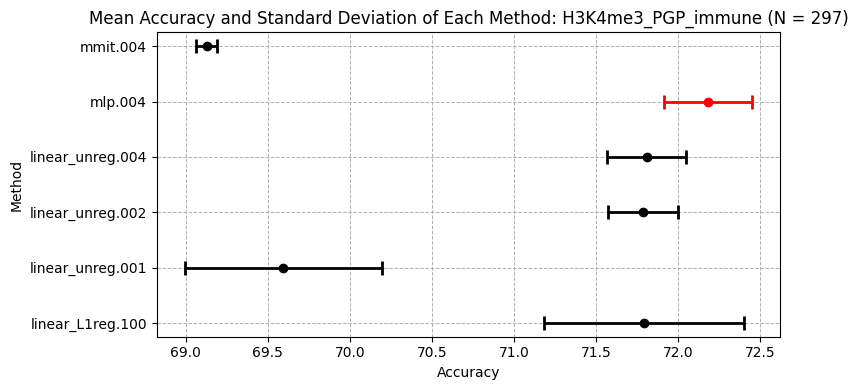

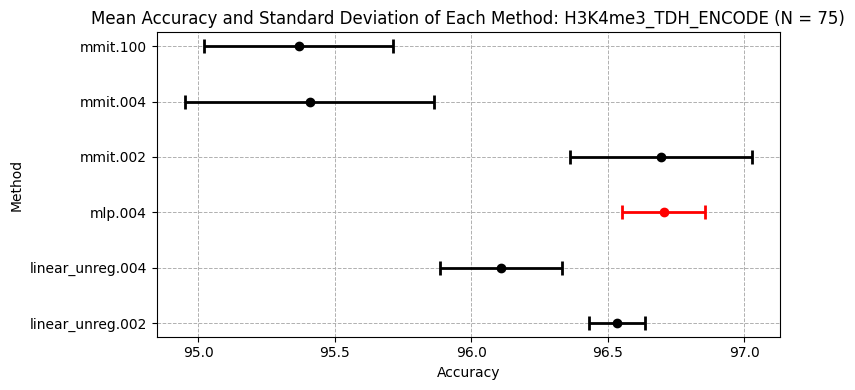

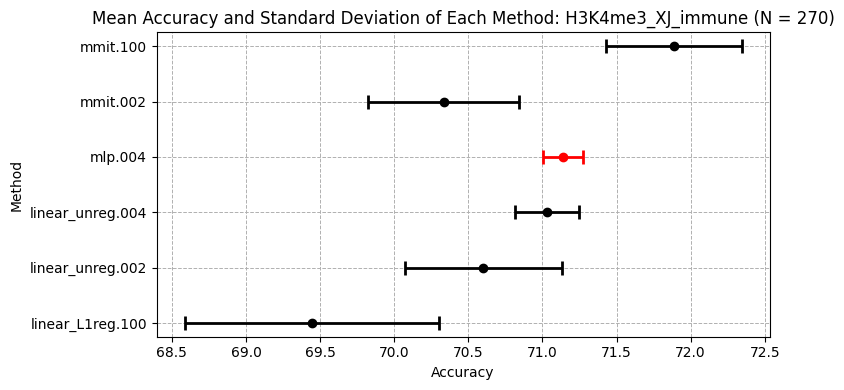

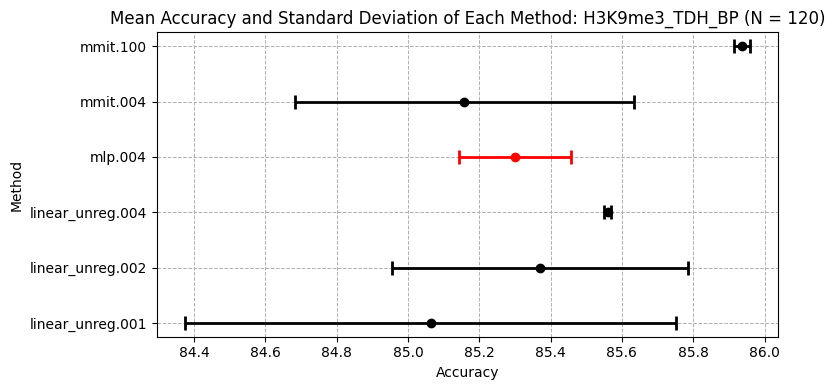

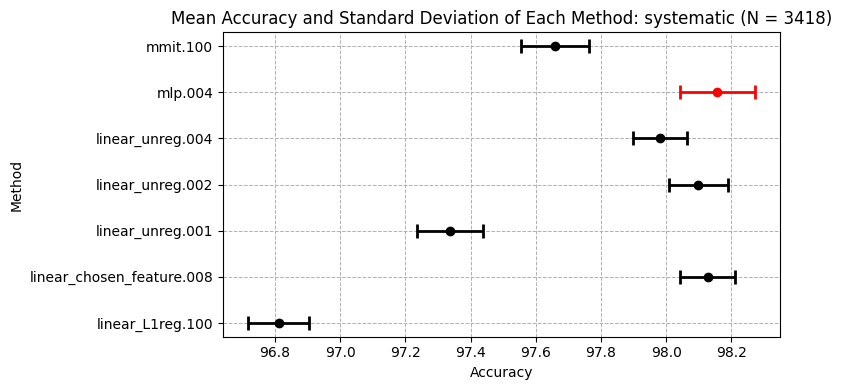

In [6]:
folder_path = '../training_data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
for dataset in datasets:
    plot(dataset)